In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sentiment140:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2477%2F4140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T161850Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db61f944d9388ea7f89254da331a10ab6ba17835e9f37701d234bc0b933c5b19061987d4ff3fd19408d07f1061d12c6575a31d586beb6f94eaf8ce78472a2d0adc0ce228c1ac444a4b8de12955fd66449b615c42549b0ad2d8e776237b4b114e8cf83acbb6fae7b2d9ea7464e2ae43a6f3136bebf00e78ce9aeec78b9c2a3734480120eb89f3d7ea3255ba7364f368db05ca0c4e3d5c5df81512fa20bfbcc41c76c996ecd25c00a1647d22b5b4d6bd1ab2b64af338be2f5a3bf089a454c7db7c2e43a459ab4599ab0ac28b42b355426ecaac3267e1f19c7ab47d167e5ae5754563d465070285dfe12ca424dfa927548e8dbd5fd2105c9f9dbd02f17f830106ac5,twitter-sentiment-analysis-hatred-speech:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F100982%2F239192%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T161850Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D80b9358c94e61a88e1abb109b56daeb48f62e24bb0ab1af37bf2f12595f1e85b56889f434664a11a52be61d4052a84d58305ed251112bee2123dc65a3ceb91c45c59baaf60898928db44fd28509d72e9a07d919293be12e42f779e7eead5d5834a5770f44a5ea7ef2a2b34b3a6bd462efdb9c90bcd4e12d84d94eaabe2991a6403a84b42f7b2f9ec6a622157426e881e55df3b568902f57f94a424d89b898c4fa530534ec2726bc7213e664b4a6cb110405ba8648150d48513b450c2a114714c1605c5c7cd96b502aa5aebeb545d0e42bd37bf853f36620160a729ec2c22764a3443cfc8378c7aac143c52e222651e259098849e8de5b6d546b215cedeb43134,twitter-airline-sentiment:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17%2F742210%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T161850Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D987edafe01e5adeaa4e0c338afdb70aea83ebcf0e1c49fb2125cb4ac3a445020c0ad24fb944b8911edd3deaa286466ebcb7cb72dfc10d5d65166f7e38406e045464747a0c7dd20ecf8547cbda4f4493c5eb2647aec91c6047198bb0ea3ad02a43449f0f756059dc3b95547cf8de66a7eba7cbaaa52ca599e32e707ac643040d4b6f1edc065095a14f94cf4394e27659c827f60af4375c2d739b2ab7da6e5d7d520da8d2d0bb9645e0d0825e9f8c698680c023ab5455c965e847e2e2253cf2cbfe08dee7051bc7753ab7ac9cdc1aa86369f47930b6ac383d1045911b66a619a4bf013404addad19b766bd9a1a7f71064a5701494a32a36b837a0edd11f58ac4f8,smile-twitter-emotion-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F773597%2F1332516%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241005%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241005T161850Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D864658bf53d4190f1a61307b79b8fdba2d73aead0190a4c30e2a9b357b82df20b53630efa318b6c7bc46227b5e14c9be07656787d26465d5c22b649965791630eda0cad156805ab857fcd96fa46fc21cff5c0f643d7c374d3526ce8217cad99edc9358c7ebd192f0442e2c3e18df4831394f11b543ded79c9fc7006e7ae7dfe427eb9dd7eb5be83c2350506c6576d8c4eaa292178a85c8d5dfc058977a5f2cad86d4296fe7eac5abf6a556ead4e694a47fd51ce54064a7cbf98c80f5b352c71243e1bf995c43e9703d43ab1f7d61cb8a6945f54c8547db8dbacf52aee7f3309df8ccfe9e753af4107b123ed8f82b910926fa6f196907c672487559e98c39ae44'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 84855679 bytes downloaded
Downloaded and uncompressed: sentiment140
[==================================================] 1982527 bytes downloaded
Downloaded and uncompressed: twitter-sentiment-analysis-hatred-speech
[==================================================] 2678605 bytes downloaded
Downloaded and uncompressed: twitter-airline-sentiment
[==================================================] 388526 bytes downloaded
Downloaded and uncompressed: smile-twitter-emotion-dataset
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smile-twitter-emotion-dataset/smile-annotations-final.csv
/kaggle/input/smile-twitter-emotion-dataset/smile-annotations-final.json
/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite
/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv


In [ ]:
import torch
from tqdm.notebook import tqdm

Reading SMILE twitter emotion dataset

In [ ]:
df = pd.read_csv("/kaggle/input/smile-twitter-emotion-dataset/smile-annotations-final.csv",
                names = ['Id','Text','Category'])
df.set_index('Id',inplace = True)
df[:4]

,Text,Category
Id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy


In [ ]:
df.Text.iloc[0]

'@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap'

* Counts of Emotions in the dataset

In [ ]:
df.Category.value_counts()

,count
Category,
nocode,1572
happy,1137
not-relevant,214
angry,57
surprise,35
sad,32
happy|surprise,11
happy|sad,9
disgust|angry,7


We will be filtering the emotions with single emotions and ignoring the rest.

In [ ]:
df = df[(df.Category!="nocode")]
df = df[~(df.Category.str.contains("\|"))]
df.Category.value_counts()

,count
Category,
happy,1137
not-relevant,214
angry,57
surprise,35
sad,32
disgust,6


In [ ]:
possible_label = df.Category.unique()
dict_label = {}
for index,possible_label in enumerate(possible_label):
    dict_label[possible_label] = index
dict_label

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [ ]:
df["Label"] = df["Category"].replace(dict_label)
df.head()

<ipython-input-9-df97fe62896d>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Label"] = df["Category"].replace(dict_label)


,Text,Category,Label
Id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


<ipython-input-10-645e7423700d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Label"], palette = 'dark') # Removed hue parameter as it was assigned to the same value as x
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.p

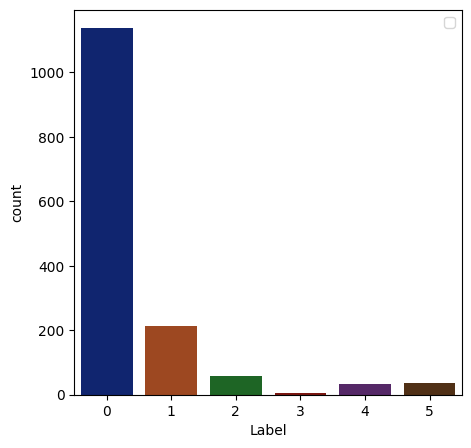

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5,5)
sns.countplot(x=df["Label"], palette = 'dark') # Removed hue parameter as it was assigned to the same value as x
plt.legend(loc = 'upper right')
plt.show()

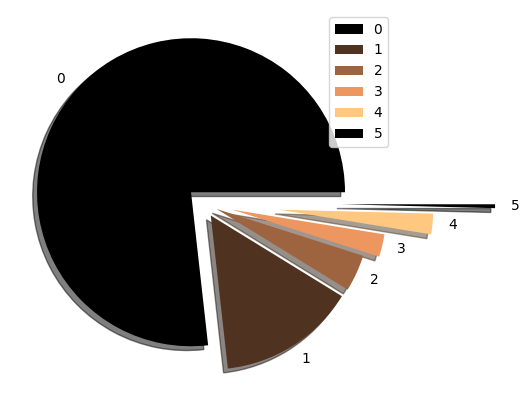

In [ ]:
labels = [0,1,2,3,4,5]
sizes = df["Label"].value_counts()
colors = plt.cm.copper(np.linspace(0, 1, 5))
explode = [0.1, 0.1,0.1, 0.2, 0.5, 0.9]
cmap = plt.get_cmap('Spectral')
plt.pie(sizes,labels = labels,colors = colors,shadow = True,explode = explode)
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df.index.values,
                                                df.Label.values,
                                                test_size = 0.15,
                                                random_state=17,
                                                stratify = df.Label.values)

In [ ]:
# df["data_type "] = ['not_set']*df.shape[0]
# df.head()

In [ ]:
# for i in df.index:
#     if i in X_train:
#         df["data_type"].replace("not_set","train")
#     elif i in X_test:
#         df["data_type"].replace("not_set","test")
# df.head()
df.loc[X_train,'data_type'] = 'train'
df.loc[X_test,'data_type'] = 'test'

In [ ]:
df.head()

,Text,Category,Label,data_type
Id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,train
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,train
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,train
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,train
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,train


In [ ]:
df.groupby(['Category','Label','data_type']).count()

Text
Category     Label data_type      
angry        2     test          9
                   train        48
disgust      3     test          1
                   train         5
happy        0     test        171
                   train       966
not-relevant 1     test         32
                   train       182
sad          4     test          5
                   train        27
surprise     5     test          5
                   train        30

# Modeling

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Encoding text by tokenizing using BERT Tokenizer
* In order to use BERT text embeddings as input to train text classification model, we need to tokenize our text reviews. Tokenization refers to dividing a sentence into individual words. To tokenize our text, we will be using the BERT tokenizer

In [ ]:
encoder_train = tokenizer.batch_encode_plus(df[df["data_type"]=='train'].Text.values,
                                           add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(df[df["data_type"]=='test'].Text.values,
                                           add_special_tokens = True,
                                            return_attention_masks = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(df[df['data_type']=='train'].Label.values)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(df[df['data_type']=='test'].Label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'return_attention_masks': True} not recognized.
Keyword arguments {'return_atten

In [ ]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)


In [ ]:
len(data_train),len(data_test)

(1258, 223)

* We will use sequence classification model as we have to classify multi label text from the dataset.

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = len(dict_label),
                                     output_attentions = False,
                                     output_hidden_states =  False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


From torch we will use data loader,randomsampler to load data in an iterable format but extracting different subsamples from dataset.

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)

epochs  = 10
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Defining Model metrics

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')


In [ ]:
def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}

    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

Loading:cuda


Defining Evaluation

In [ ]:
def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions,true_vals = [],[]

    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)


    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals


* Training Data

In [ ]:
for epoch in tqdm(range(1,epochs+1)):
    model.train()

    loss_train_total=0

    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)


    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]

        }
        outputs = model(**inputs)

        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

        optimizer.step()
        scheduler.step()


        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
#     torch.save(model.state_dict(),f'/kaggle/output/BERT_ft_epoch{epoch}.model')To save the model after each epoch

    tqdm.write('\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.859873073010505


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.7013921226773944
 Test Score:0.7191876263297022


Epoch: 2:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.575281593241269


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.5484096322740827
 Test Score:0.7793941518896502


Epoch: 3:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.43116937426826624


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.5347338914871216
 Test Score:0.7847722445126268


Epoch: 4:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.3321656233902219


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.5216555148363113
 Test Score:0.7785905754440464


Epoch: 5:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.27157952492655835


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.573435263974326
 Test Score:0.7994997602069571


Epoch: 6:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.21848049743360357


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.5427508162600654
 Test Score:0.848010476869362


Epoch: 7:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.18712884609740746


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.5591742438929421
 Test Score:0.8619957324178961


Epoch: 8:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.15577058161644242


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.566395857504436
 Test Score:0.8486159725303255


Epoch: 9:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.1323531820804258


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.5703123552458627
 Test Score:0.8468250837752275


Epoch: 10:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-30-61cbfb932624>:27: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.12105701307919395


  0%|          | 0/7 [00:00<?, ?it/s]

Val Loss:0.5792958736419678
 Test Score:0.8507233881646056


# Using the saved model

In [ ]:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
#                                      num_labels = len(dict_label),
#                                      output_attentions = False,
#                                      output_hidden_states =  False)

In [ ]:
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# #using saved model
# model.load_state_dict(torch.load("Path of saved model"))# in case want to use the saved model
# _,predictions,true_vals = evaluate(dataloader_test)
# accuracy_per_class(predictions,true_vals)

In [ ]:
_,predictions,true_vals = evaluate(dataloader_test)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
accuracy_per_class(predictions,true_vals)

Class:{0: 'happy', 1: 'not-relevant', 2: 'angry', 3: 'disgust', 4: 'sad', 5: 'surprise'}
Accuracy:166/171

Class:{0: 'happy', 1: 'not-relevant', 2: 'angry', 3: 'disgust', 4: 'sad', 5: 'surprise'}
Accuracy:19/32

Class:{0: 'happy', 1: 'not-relevant', 2: 'angry', 3: 'disgust', 4: 'sad', 5: 'surprise'}
Accuracy:8/9

Class:{0: 'happy', 1: 'not-relevant', 2: 'angry', 3: 'disgust', 4: 'sad', 5: 'surprise'}
Accuracy:0/1

Class:{0: 'happy', 1: 'not-relevant', 2: 'angry', 3: 'disgust', 4: 'sad', 5: 'surprise'}
Accuracy:0/5

Class:{0: 'happy', 1: 'not-relevant', 2: 'angry', 3: 'disgust', 4: 'sad', 5: 'surprise'}
Accuracy:1/5



In [ ]:
from sklearn.metrics import accuracy_score

def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}

    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_reverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

_, predictions, true_vals = evaluate(dataloader_test)
accuracy_per_class(predictions, true_vals)

  0%|          | 0/7 [00:00<?, ?it/s]

Class: happy
Accuracy: 166/171

Class: not-relevant
Accuracy: 19/32

Class: angry
Accuracy: 8/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 0/5

Class: surprise
Accuracy: 1/5



In [ ]:
from sklearn.metrics import accuracy_score

_, predictions, true_vals = evaluate(dataloader_test)

preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()
accuracy = accuracy_score(labels_flat, preds_flat)

print(f'Total Accuracy: {accuracy}')

  0%|          | 0/7 [00:00<?, ?it/s]

Total Accuracy: 0.8699551569506726
